In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn.preprocessing
from tqdm import tqdm

2022-09-11 12:09:16.856253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 12:09:21.325693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-11 12:09:21.325805: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-11 12:09:22.064005: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-11 12:09:38.472523: W tensorflow/stream_executor/platform/de

In [3]:
sns.set_theme(style="white")

In [22]:
PATH = "Projects/3W/dataset"
NORMAL_CLASS = 0
# In this case, we will consider the benchmark proposed by Vargas (2019), with real instances that have windows of more 
# than 20 minutes.
ABNORMAL_CLASSES = [1, 2, 5, 6, 7, 8]

In [20]:
os.chdir(os.getenv("HOME"))

In [23]:
files = []

for file in os.listdir( os.path.join(PATH, str(NORMAL_CLASS)) ):
    file_path = os.path.join(PATH, str(NORMAL_CLASS), file)
    if "WELL" not in file_path:
        continue
        
    files.append(file_path)

In [45]:
def resample_data(data: pd.DataFrame, sample: str = '3S') -> pd.DataFrame:
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.set_index("timestamp")
    
    return data.resample(sample).mean()

In [99]:
data = pd.DataFrame()
c = 0
for file in files:
    if c > 15:
        break
    
    temp_data = pd.read_csv(file)
    temp_data = resample_data(temp_data)
    data = pd.concat([data, temp_data])
    c += 1

In [100]:
data = data.drop("class", axis=1)
data = data.fillna(0)

In [101]:
scaler = sklearn.preprocessing.StandardScaler()
preprocessed_data = scaler.fit_transform(data)
preprocessed_data = pd.DataFrame(data=preprocessed_data, columns=data.columns)

Text(0.5, 1.0, 'TPT Pressure')

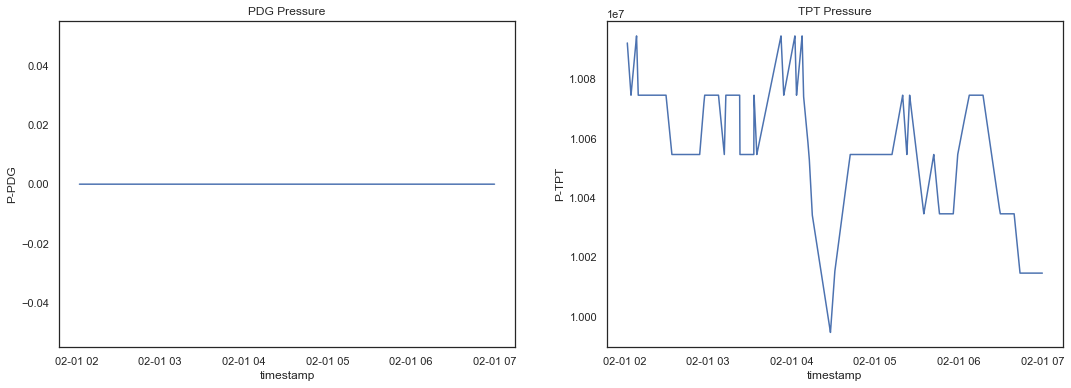

In [16]:
f, ax = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(data=data["P-PDG"], ax=ax[0])
sns.lineplot(data=data["P-TPT"], ax=ax[1])
ax[0].set_title("PDG Pressure")
ax[1].set_title("TPT Pressure")

<AxesSubplot:xlabel='timestamp', ylabel='T-JUS-CKP'>

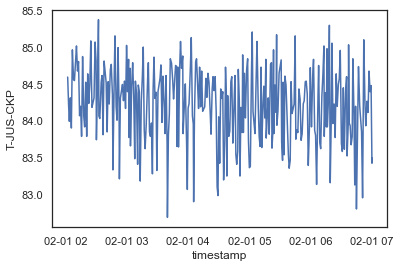

In [14]:
sns.lineplot(x="timestamp", y="T-JUS-CKP", data=data)

<AxesSubplot:xlabel='timestamp', ylabel='P-JUS-CKGL'>

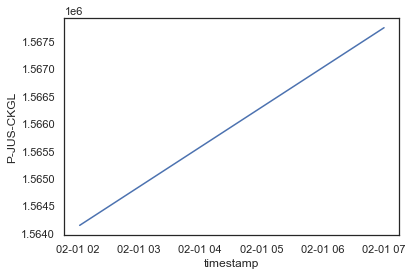

In [17]:
sns.lineplot(x="timestamp", y="P-JUS-CKGL", data=data)

In [50]:
STEPS = 10

In [51]:
def create_sequence(data, steps=STEPS):
    xs, ys = [], []
    for i in tqdm(range(len(data) - steps)):
        xs.append(data.iloc[i:(i+steps)].values)
        ys.append(data.iloc[i+steps].values)
        
    return np.array(xs), np.array(ys)

In [105]:
x_train, y_train = create_sequence(preprocessed_data)

100%|██████████| 89137/89137 [00:28<00:00, 3078.41it/s]


In [109]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(x_train.shape[2])))

opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=opt, loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            18688     
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 8)            520       
 tributed)                                                       
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


In [110]:
y_train = y_train.reshape(y_train.shape[0], 1, 8)

In [111]:
h = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.3,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
              shuffle=False)

2022-09-11 12:56:24.950415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19966400 exceeds 10% of free system memory.


Epoch 1/20
1950/1950 [==============================] - 69s 32ms/step - loss: 0.3688 - val_loss: 0.2275
Epoch 2/20
1950/1950 [==============================] - 62s 32ms/step - loss: 0.1628 - val_loss: 0.1766
Epoch 3/20
1950/1950 [==============================] - 64s 33ms/step - loss: 0.1044 - val_loss: 0.1536
Epoch 4/20
1950/1950 [==============================] - 64s 33ms/step - loss: 0.0769 - val_loss: 0.1447
Epoch 5/20
1950/1950 [==============================] - 64s 33ms/step - loss: 0.0612 - val_loss: 0.1390
Epoch 6/20
1950/1950 [==============================] - 65s 33ms/step - loss: 0.0516 - val_loss: 0.1353
Epoch 7/20
1950/1950 [==============================] - 65s 33ms/step - loss: 0.0446 - val_loss: 0.1297
Epoch 8/20
1950/1950 [==============================] - 65s 33ms/step - loss: 0.0393 - val_loss: 0.1252
Epoch 9/20
1950/1950 [==============================] - 65s 33ms/step - loss: 0.0349 - val_loss: 0.1226
Epoch 10/20
1950/1950 [==============================] - 69s 35m

Text(0, 0.5, 'MAE')

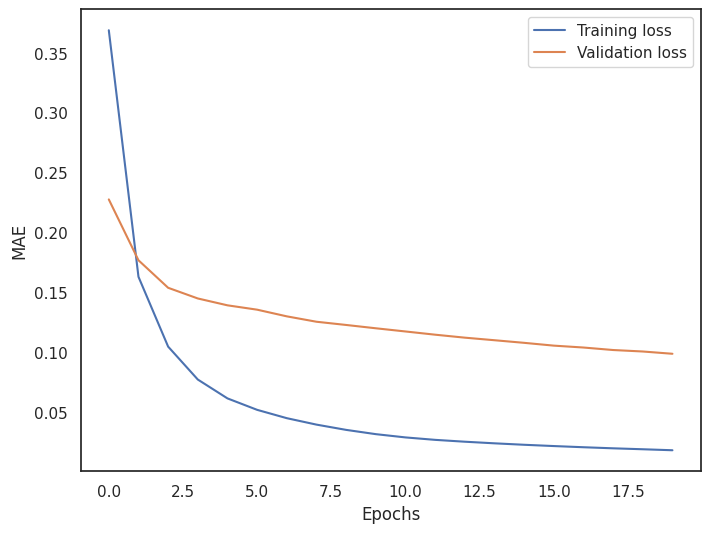

In [112]:
plt.figure(figsize=(8,6))
plt.plot(h.history['loss'], label='Training loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("MAE")

In [113]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

2022-09-11 13:32:42.471547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28523840 exceeds 10% of free system memory.


2786/2786 [==============================] - 36s 12ms/step


2022-09-11 13:33:22.414945: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28523840 exceeds 10% of free system memory.


In [116]:
thresholds = np.max(train_mae_loss, axis=0)

print('Reconstruction error threshold:')
for variable, threshold in zip(data.columns, thresholds):
    print(f"{variable}: {round(threshold, 2)}")

Reconstruction error threshold:
P-PDG: 1.05
P-TPT: 0.59
T-TPT: 0.7
P-MON-CKP: 0.47
T-JUS-CKP: 1.5
P-JUS-CKGL: 1.2
T-JUS-CKGL: 0.08
QGL: 0.1


### Test

In [117]:
test_data = pd.read_csv("Projects/3W/dataset/1/WELL-00006_20170801063614.csv")
test_data = resample_data(test_data)

test_data = test_data.drop("class", axis=1)
preprocessed_test_data = scaler.transform(test_data)

preprocessed_test_data = pd.DataFrame(data=preprocessed_test_data, columns=data.columns)
preprocessed_test_data = preprocessed_test_data.fillna(0)

In [118]:
x_test, y_test = create_sequence(preprocessed_test_data)

100%|██████████| 16456/16456 [00:05<00:00, 2808.52it/s]


In [119]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

515/515 [==============================] - 7s 13ms/step


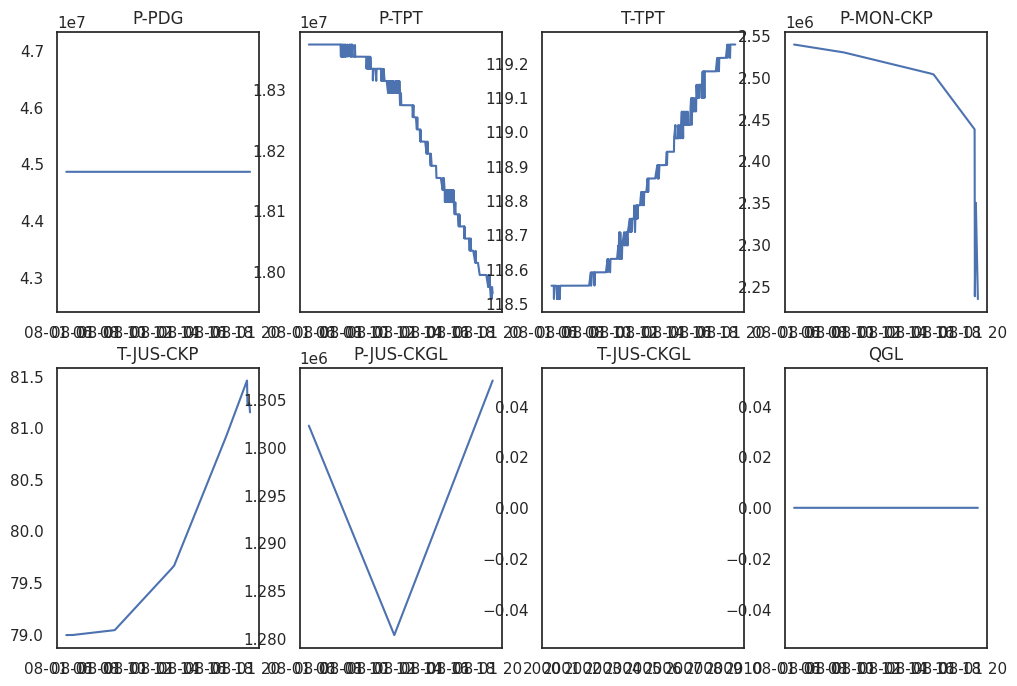

In [74]:
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
for i in range(2):
    for j in range(4):
        ax[i][j].plot(test_data[test_data.columns[i*4 + j]])
        ax[i][j].set_title(data.columns[i*4 + j])

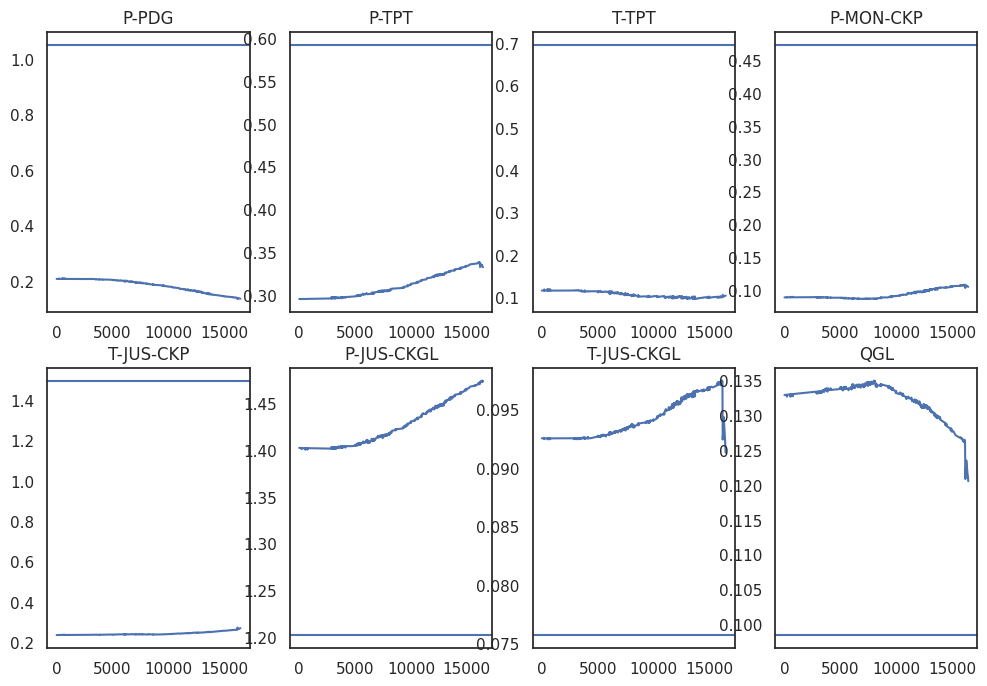

In [131]:
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
for i in range(2):
    for j in range(4):
        ax[i][j].axhline(thresholds[i*4 + j])
        ax[i][j].plot(test_mae_loss[:, i*4 + j])
        ax[i][j].set_title(data.columns[i*4 + j])

In [130]:
thresholds

array([1.05391396, 0.59288817, 0.69708129, 0.47456529, 1.49984395,
       1.20292278, 0.07572361, 0.0985053 ])

In [129]:
(test_mae_loss > thresholds)

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [121]:
pd.concat([test_data.reset_index(), pd.Series((test_mae_loss > thresholds).any(axis=1), name="anomaly")], axis=1)

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,anomaly
0,2017-08-01 06:36:12,44858050.0,1.837356e+07,118.5515,2.538996e+06,78.989690,1302262.0,NaN,0.0,True
1,2017-08-01 06:36:15,44858050.0,1.837356e+07,118.5515,2.538995e+06,78.989690,1302260.0,NaN,0.0,True
2,2017-08-01 06:36:18,44858050.0,1.837356e+07,118.5515,2.538993e+06,78.989690,1302257.0,NaN,0.0,True
3,2017-08-01 06:36:21,44858050.0,1.837356e+07,118.5515,2.538990e+06,78.989690,1302254.0,NaN,0.0,True
4,2017-08-01 06:36:24,44858050.0,1.837356e+07,118.5515,2.538988e+06,78.989690,1302251.0,NaN,0.0,True
...,...,...,...,...,...,...,...,...,...,...
16461,2017-08-01 20:19:15,44858050.0,1.796485e+07,119.2546,2.238312e+06,81.153923,1306976.0,NaN,0.0,NaN
16462,2017-08-01 20:19:18,44858050.0,1.796466e+07,119.2546,2.237681e+06,81.152690,1306979.0,NaN,0.0,NaN
16463,2017-08-01 20:19:21,44858050.0,1.796446e+07,119.2546,2.237050e+06,81.151443,1306982.0,NaN,0.0,NaN
16464,2017-08-01 20:19:24,44858050.0,1.796427e+07,119.2546,2.236111e+06,81.150210,1306985.0,NaN,0.0,NaN
